## This jupyter notebook contains deep dive in the data provided by Swiggy to understand the data, customers and to predict individual customer's spend in last 7 days.

In [1]:
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tqdm
import cv2
from scipy.spatial import distance
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import datetime
import seaborn as sns

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#sneak peek of data

os.chdir('D:/data_science/swiggy')
data = pd.read_csv('SampleAssessment.csv')
print(data.columns)
print(data.shape)
print(data.dtypes)
data.head(5)

Index(['customer_id', 'First Time', 'Recent Time', '# of Orders',
       '# of Orders in last 7 days', '# of Orders in last 4 weeks', 'Amount',
       'Amount in last 7 days', 'Amount in last 4 weeks',
       'Avg_DistanceFromResturant', 'Avg_DeliveryTime'],
      dtype='object')
(10000, 11)
customer_id                      int64
First Time                      object
Recent Time                     object
# of Orders                      int64
# of Orders in last 7 days     float64
# of Orders in last 4 weeks    float64
Amount                           int64
Amount in last 7 days            int64
Amount in last 4 weeks           int64
Avg_DistanceFromResturant      float64
Avg_DeliveryTime                 int64
dtype: object


,customer_id,First Time,Recent Time,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
0,28,11/22/2015 16:14,12/13/2015 1:37,1,NaN,1.0,558,0,558,0.8,33
1,122,7/20/2015 3:38,11/15/2015 16:28,2,NaN,NaN,2685,0,0,2.6,24
2,152,9/10/2015 4:26,8/26/2015 7:14,12,2.0,5.0,2608,382,1286,2.6,31
3,173,8/4/2015 10:14,9/11/2015 21:47,9,NaN,NaN,1634,0,0,1.2,45
4,204,8/14/2015 19:23,11/14/2015 17:56,2,NaN,NaN,562,0,0,2.0,53


In [442]:
#Missing value check
missing = pd.DataFrame(data.apply(lambda x: np.sum(x.isnull(), axis=0)))
missing['percentage_missing'] = (missing.iloc[:,0]/data.shape[0])*100
print(missing)

                                0  percentage_missing
customer_id                     0                0.00
First Time                      0                0.00
Recent Time                     0                0.00
# of Orders                     0                0.00
# of Orders in last 7 days   8077               80.77
# of Orders in last 4 weeks  5659               56.59
Amount                          0                0.00
Amount in last 7 days           0                0.00
Amount in last 4 weeks          0                0.00
Avg_DistanceFromResturant       0                0.00
Avg_DeliveryTime                0                0.00


### There are significant proportion of missing values for # of Orders in last 7 days,# of Orders in last 4 weeks. Most likely it is because of the customers didn't order. We can validate our hypothesis and accordingly apply missing value treatment - replace NA as zero.

In [444]:
#Validation
print('sum of order amount in last 7 days for customers,having missing value', np.sum(data['Amount in last 7 days'][data['# of Orders in last 7 days'].isna()]>0))
print('sum of order amount in last 4 weeks for customers,having missing value',np.sum(data['Amount in last 4 weeks'][data['# of Orders in last 4 weeks'].isna()]>0))

#Amount for these missing values are zero, so it's logical to replace missing values as 0
data['# of Orders in last 7 days'].fillna(0, inplace = True)
data['# of Orders in last 4 weeks'].fillna(0, inplace = True)
missing = pd.DataFrame(data.apply(lambda x: np.sum(x.isnull(), axis=0)))
missing['percentage_missing'] = (missing.iloc[:,0]/data.shape[0])*100
print(missing)

sum of order amount in last 7 days for customers,having missing value 0
sum of order amount in last 4 weeks for customers,having missing value 0
                             0  percentage_missing
customer_id                  0                 0.0
First Time                   0                 0.0
Recent Time                  0                 0.0
# of Orders                  0                 0.0
# of Orders in last 7 days   0                 0.0
# of Orders in last 4 weeks  0                 0.0
Amount                       0                 0.0
Amount in last 7 days        0                 0.0
Amount in last 4 weeks       0                 0.0
Avg_DistanceFromResturant    0                 0.0
Avg_DeliveryTime             0                 0.0


### We will do some essential feature engineering to gather customer insights and for our predictive model and defining components of end prediction metric(customer's spend in last 7 days) to create following broad type variables. The name and logic of these created features are self-explanatory

##### a) How long the customer is with Swiggy('cust_age')
##### b) Amount per order('amount_per_order','amount_per_order_7days' , 'amount_per_order_4weeks','amount_last_3weeks')
##### c) Order_per_week('order_per_week_overall', 'order_per_week_4weeks','order_per_week_3weeks')
##### d) Indicator vaiable whether the customer ordered or not('order_flag_4weeks','order_flag_3weeks') 
##### e) Some velocity variable-order pattern change(if any) in recent time w.r.t. overall('recent_change_amount_per_order')

In [457]:
#Feature engineering

#Date conversion
data['First Time'] = pd.to_datetime(data['First Time'])
data['cust_age'] = ((pd.Timestamp(datetime.datetime.now())-pd.to_datetime(data['First Time'])).astype('<m8[D]'))/7
data['amount_per_order'] = data['Amount']/data['# of Orders']
data['order_per_week_overall'] = data['# of Orders']/data['cust_age']
data['amount_per_order_7days'] = data['Amount in last 7 days']/(data['# of Orders in last 7 days'] + 10**-9)
data['amount_per_order_4weeks'] = data['Amount in last 4 weeks']/(data['# of Orders in last 4 weeks'] + 10**-9)
data['order_per_week_4weeks'] = (data['# of Orders in last 4 weeks'])/4
data['recent_change_amount_per_order'] = data['amount_per_order_4weeks']-data['amount_per_order']
data['order_flag_4weeks'] = np.where(data['# of Orders in last 4 weeks'] == 0,0,1)
data['amount_before_lastweek'] = data['Amount']-data['Amount in last 7 days']
data['order_before_lastweek'] = data['# of Orders']-data['# of Orders in last 7 days']
data['amount_last_3weeks'] = data['Amount in last 4 weeks']-data['Amount in last 7 days']
data['order_last_3weeks'] = data['# of Orders in last 4 weeks']-data['# of Orders in last 7 days']
data['amount_per_order_3weeks'] = data['amount_last_3weeks']/(data['order_last_3weeks'] + 10**-9)
data['order_per_week_3weeks'] = (data['order_last_3weeks'])/3
data['order_flag_3weeks'] = np.where(data['order_last_3weeks'] == 0,0,1)
data['orderflag_last_7days'] = np.where(data['# of Orders in last 7 days'] == 0,0,1)
print(data.head())
missing = pd.DataFrame(data.apply(lambda x: np.sum(x.isnull(), axis=0)))
missing['percentage_missing'] = (missing.iloc[:,0]/data.shape[0])*100
print(missing)

   customer_id          First Time       Recent Time  # of Orders  \
0           28 2015-11-22 16:14:00   12/13/2015 1:37            1   
1          122 2015-07-20 03:38:00  11/15/2015 16:28            2   
2          152 2015-09-10 04:26:00    8/26/2015 7:14           12   
3          173 2015-08-04 10:14:00   9/11/2015 21:47            9   
4          204 2015-08-14 19:23:00  11/14/2015 17:56            2   

   # of Orders in last 7 days  # of Orders in last 4 weeks  Amount  \
0                         0.0                          1.0     558   
1                         0.0                          0.0    2685   
2                         2.0                          5.0    2608   
3                         0.0                          0.0    1634   
4                         0.0                          0.0     562   

   Amount in last 7 days  Amount in last 4 weeks  Avg_DistanceFromResturant  \
0                      0                     558                        0.8   
1     

#### We may not able to use all these derived variables in our predictive model,because of Data leakage. For example we can't use 'order_per_week_4weeks' variable to predict customer's spend in last 7 days, as Data for 4 weeks is a superset of data for 7 days.So to predict customer's spend(or other metric) in last 7 days, we can use information till previous week of in last 7 days(e.g. we can use features like 'amount_last_3weeks','order_flag_3weeks' etc., but can't use 'order_flag_4weeks'). 

#### However for business insight,exploratory analysis and customer segmentation we can use the data till present(till last 7 days).

Text(0,0.5,'Frequency')

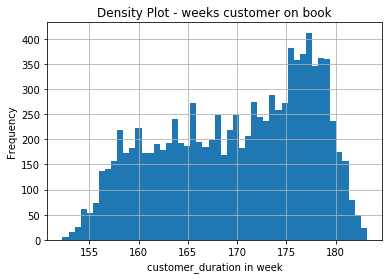

In [204]:
#Business Insight

#customer age
data['cust_age'].hist(bins=50)
# Plot formatting
plt.title('Density Plot - weeks customer on book')
plt.xlabel('customer_duration in week')
plt.ylabel('Frequency')

#### Most of customers have spent similar duration with Swiggy- around 155 weeks to 180 weeks, i.e. there is not much variance in customers' age(duration).

C:\Users\Sourish\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

C:\Users\Sourish\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in less



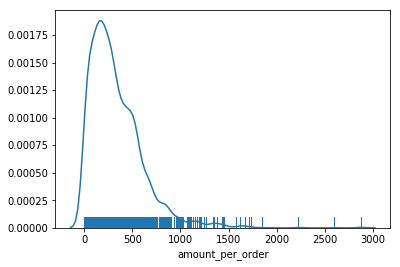

In [161]:
#amount per order distribution- overall
sns.distplot(data['amount_per_order'][data['amount_per_order']], hist = False, kde = True,rug=True,
                 kde_kws = {'linewidth': 1.5})

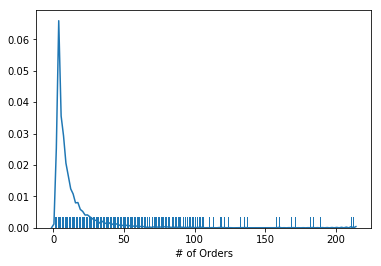

In [169]:
#no of order distribution- overall
sns.distplot(data['# of Orders'], hist = False, kde = True,rug=True,
                 kde_kws = {'linewidth': 1.5})

(array([9.837e+03, 1.380e+02, 1.600e+01, 7.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0.        , 0.29166667, 0.58333333, 0.875     , 1.16666667,
        1.45833333, 1.75      , 2.04166667, 2.33333333, 2.625     ,
        2.91666667, 3.20833333, 3.5       , 3.79166667, 4.08333333,
        4.375     , 4.66666667, 4.95833333, 5.25      , 5.54166667,
        5.83333333, 6.125     , 6.41666667, 6.70833333, 7.        ]),
 <a list of 24 Patch objects>)

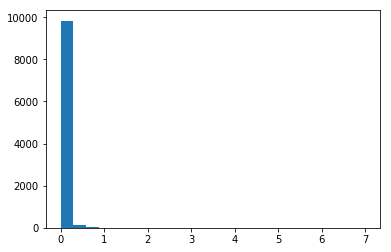

In [456]:
#no of order distribution- overall
bins = np.linspace(0, 7, 25)
plt.hist(data['order_per_week_overall'],bins)

#### Average individual bill amount is with in INR 1000 and on an average most customers order(if order) mostly once in a week.

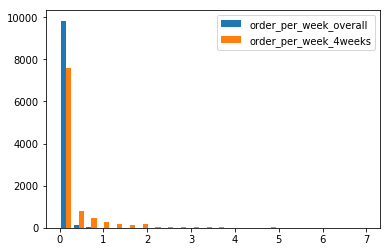

In [193]:
#trend in no of orders/week in recent times

bins = np.linspace(0, 7, 25)
plt.hist([data['order_per_week_overall'], data['order_per_week_4weeks']], bins, label=['order_per_week_overall', 'order_per_week_4weeks'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('order is:%f:')

percent of customer ordered in last one month is: 43.410000 percent
percent of customer ordered in last one week is: 19.230000 percent


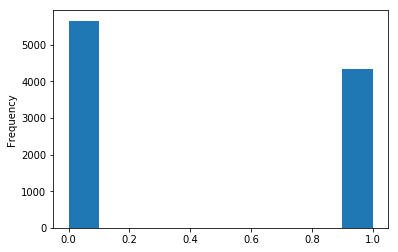

In [461]:
#Distribution of order vs. no order in recent time

data['order_flag_4weeks'].astype(int).plot.hist()
print('percent of customer ordered in last one month is: %f percent' %((data['order_flag_4weeks'].value_counts()[1]/data['order_flag_4weeks'].shape[0]) * 100))
print('percent of customer ordered in last one week is: %f percent' %((data['orderflag_last_7days'].value_counts()[1]/data['orderflag_last_7days'].shape[0]) * 100))

#### Good news for business is that on an average there is a increase in order/week in last one month compared to the same in overall. However only 43.41% customers placed atleast one order in last one month and only 19.23% in last week. May be some marketing campaign or special offer may work for these inactive customers(approx 57%).

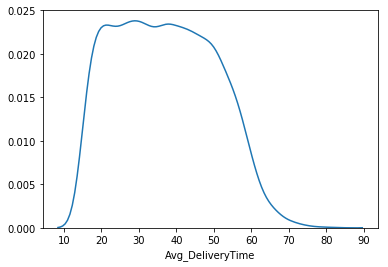

In [170]:
#average delivery time
sns.distplot(data['Avg_DeliveryTime'], hist = False, kde = True,rug=False,
                 kde_kws = {'linewidth': 1.5})

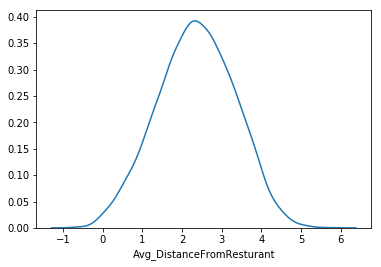

In [194]:
#where from they order
sns.distplot(data['Avg_DistanceFromResturant'], hist = False, kde = True,rug=False,
                 kde_kws = {'linewidth': 1.5})

#### This gives us some insight about operational metrics like delivery time, restaurant inventory with Swiggy and route optimization. Mostly the waiting time for customers is eual or less than 1 hour and customers find their choice of restaurants in neighbouring areas. 

### Segmentation of customers and insights on some specific customer segments

- ### *Solution*

#### Kmeans clustering technique, which works in hard cluster assignment principle, is one the most popular unsupervised customer segmentation techniques in business as it is easy to interpret and Implement and less run time. There are other probabilistic(soft assignment) techniques such as GMM(Gaussian Mixture Model), which also may be worth trying. Here we will explore this through Kmeans technique. 

#### At the last we will provide few illustrative insights on some specific customer segments.  

#### To start with Kmeans clustering It is recommended to normalize the data before clustering. We have done MinMax normalization (linear transformation of x to (x-min)/(max-min))


In [275]:
#Customer segmentation- kmeans cluster approach

data.columns
segmentation_data = data[['# of Orders',
       '# of Orders in last 4 weeks', 'Amount',
       'Amount in last 4 weeks',
       'Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age','amount_per_order', 'order_per_week_overall', 'amount_per_order_4weeks',
       'order_per_week_4weeks']]
from sklearn import preprocessing

x = segmentation_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
segmentation_data = pd.DataFrame(x)

#Handling categorical data- order flag last 4 weeks
order_flag_4weeks = pd.get_dummies(data['order_flag_4weeks'])
segmentation_data = pd.concat([segmentation_data,order_flag_4weeks], axis=1)
segmentation_data.columns = ['# of Orders',
       '# of Orders in last 4 weeks', 'Amount',
       'Amount in last 4 weeks',
       'Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age','amount_per_order', 'order_per_week_overall', 'amount_per_order_4weeks',
       'order_per_week_4weeks','orderflag_4weeks_0','orderflag_4weeks_1']
segmentation_data.head(2)

,# of Orders,# of Orders in last 4 weeks,Amount,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,cust_age,amount_per_order,order_per_week_overall,amount_per_order_4weeks,order_per_week_4weeks,orderflag_4weeks_0,orderflag_4weeks_1
0,0.000000,0.021739,0.004013,0.02078,0.238806,0.264706,0.212963,0.056319,0.000708,0.056327,0.021739,0,1
1,0.004739,0.000000,0.019336,0.00000,0.507463,0.132353,0.796296,0.135510,0.004981,0.000000,0.000000,1,0


#### We will try to find out optimal nos of clusters from a range of options, minimizing cdist(The standardized Euclidean distance between two n-vectors)

In [240]:
#Kmeans

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
clusters=range(3,6)
meandist=[]

# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(segmentation_data)
    clusassign=model.predict(segmentation_data)
    meandist.append(sum(np.min(cdist(segmentation_data, model.cluster_centers_, 'euclidean'), axis=1))
    / segmentation_data.shape[0])

#### Elbow method is a method to determine the number of clusters

Text(0.5,1,'Selecting k with the Elbow Method')

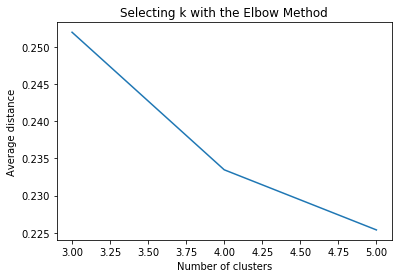

In [276]:
#Plot average distance from observations from the cluster centroid
#to use the Elbow Method to identify number of clusters to choose

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance

In [277]:
#From the elbow plot we choose no of cluster as 5

model=KMeans(n_clusters=5)
model.fit(segmentation_data)
clust_assign=model.predict(segmentation_data) 
print(model.cluster_centers_)

[[ 1.50489483e-02 -7.18175519e-16  9.46599564e-03 -6.38378239e-16
   4.53974223e-01  1.71962328e-01  7.38830563e-01  3.45707661e-02
   1.55266006e-02 -5.16947596e-16 -7.18175519e-16  1.00000000e+00
   2.08721929e-14]
 [ 1.15026699e-02  4.72648752e-02  8.41956686e-03  2.79115956e-02
   4.74417739e-01  3.04808344e-01  2.55393830e-01  3.67745416e-02
   1.33690376e-02  3.73278521e-02  4.72648752e-02 -3.14193116e-14
   1.00000000e+00]
 [ 3.54210871e-03 -7.18175519e-16  4.59506657e-03 -6.38378239e-16
   4.58104353e-01  2.90095065e-01  3.91767879e-01  3.95214492e-02
   4.37477434e-03 -5.16947596e-16 -7.18175519e-16  1.00000000e+00
   2.09832152e-14]
 [ 8.88252871e-02  9.00579839e-02  4.42863711e-02  4.93824490e-02
   4.69319332e-01  3.20577810e-01  7.72891744e-01  3.43514189e-02
   9.03447404e-02  3.50717899e-02  9.00579839e-02 -3.33066907e-14
   1.00000000e+00]
 [ 1.34435576e-02 -7.04297731e-16  9.73950137e-03 -6.27969898e-16
   5.00591505e-01  5.32940538e-01  7.11120662e-01  3.67702648e-02


#### Now it's time to get some insights about customer segements from cluster analysis result. 

In [278]:
#Merging cluster assignment data with cluster variables- cluster variables means by cluster

segmentation_data.reset_index(level=0, inplace = True)
clustlist = list(segmentation_data['index'])
lebels = list(model.labels_)
new_list = dict(zip(clustlist,lebels))
new_list = dict(zip(clustlist,lebels))
new_clust = pd.DataFrame.from_dict(new_list, orient = 'index')
new_clust.columns = ['cluster']
new_clust.reset_index(level=0, inplace = True)
merged_kmeans = pd.merge(segmentation_data,new_clust,on='index')
merged_kmeans.head(5)

,index,# of Orders,# of Orders in last 4 weeks,Amount,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,cust_age,amount_per_order,order_per_week_overall,amount_per_order_4weeks,order_per_week_4weeks,orderflag_4weeks_0,orderflag_4weeks_1,cluster
0,0,0.000000,0.021739,0.004013,0.02078,0.238806,0.264706,0.212963,0.056319,0.000708,0.056327,0.021739,0,1,1
1,1,0.004739,0.000000,0.019336,0.00000,0.507463,0.132353,0.796296,0.135510,0.004981,0.000000,0.000000,1,0,0
2,2,0.052133,0.108696,0.018781,0.04789,0.507463,0.235294,0.555556,0.021930,0.055707,0.025963,0.108696,0,1,3
3,3,0.037915,0.000000,0.011765,0.00000,0.298507,0.441176,0.726852,0.018319,0.039247,0.000000,0.000000,1,0,4
4,4,0.004739,0.000000,0.004042,0.00000,0.417910,0.558824,0.675926,0.028357,0.005188,0.000000,0.000000,1,0,4


In [279]:
#Custer representation
merged_kmeans['cluster'].value_counts()

3    2257
1    2084
2    1912
0    1905
4    1842
Name: cluster, dtype: int64

#### Variable means of respective clusters will provide features of each cluster/customer segment.

In [280]:
#Variable Means of respective clusters- These mean values are nomalised between 0 and 1
clust_grp = merged_kmeans.groupby('cluster').mean()
print('clustering variable means by cluster')
print(clust_grp)

clustering variable means by cluster
               index  # of Orders  # of Orders in last 4 weeks    Amount  \
cluster                                                                    
0        4014.125459     0.015049                     0.000000  0.009466   
1        6474.121881     0.011503                     0.047265  0.008420   
2        5615.870293     0.003542                     0.000000  0.004595   
3        4721.133363     0.088825                     0.090058  0.044286   
4        4051.508686     0.013444                     0.000000  0.009740   

         Amount in last 4 weeks  Avg_DistanceFromResturant  Avg_DeliveryTime  \
cluster                                                                        
0                      0.000000                   0.453974          0.171962   
1                      0.027912                   0.474418          0.304808   
2                      0.000000                   0.458104          0.290095   
3                      0.04938

##### The above cluster variables means by cluster is quite insightful and provides key information in terms of customers' spend behaviour(e.g.Amount in last 4 weeks), ordering behaviour(# of Orders,order_per_week_overall etc.), customer loyalty and recent activity(e.g.Number of addresses customer held in the last 5 years) about different customer segments(clusters).Following are a few examples of data driven insights from customer segmentation with k-means clustering, which would help business to make targeting and pricing strategy customized to each segment.

a)In terms of recent order placement Customer segment 1 and 3(cluster 1 and 3)are most active in Swiggy and these are the customers placed orders in last 1 month.Also in terms of duration customer segment 1 is the youngest segment.

b)Overall in terms of loyalty and valuation segment 3 is the most valuable customer to Swiggy, having highest spend(Amount, Amount in last 4 weeks etc.).Also in terms of duration they are the oldest customers of Swiggy.Swiggy marketing effort should put all efforts to retain this customer segment.

c) Customer segment 2 has the most inactive customers(in terms of CLTV least), both in recent time as well as in overall duration with Swiggy, having disproportionately less order placement, spend and recent activity. Swiggy may send some temporary(time-bound) customized offer/promo for this segment to increase the stickiness. 

d) Also for the customers, who ordered at least once in recent time, it's evident that over the time on an average customers spend behaviour(amount/order) doesn't change significantly.

There are many more interesting facts hidden in the above analysis and with thorough study business can decipher many more intriguing patterns amongst these segments

- ### Predicting customer spend in last 7 days based on past.

##### Before structuring the approach/solution, let's first explore customers spend behaviour last 7 days.


{'whiskers': [<matplotlib.lines.Line2D at 0x27930aad5f8>,
 'caps': [<matplotlib.lines.Line2D at 0x27930aadeb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x27930aad4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x27930ab6748>],
 'fliers': [<matplotlib.lines.Line2D at 0x27930ab6b70>],
 'means': []}

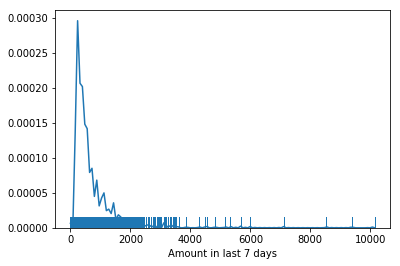

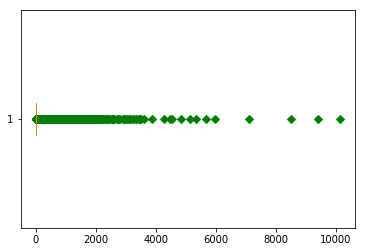

In [462]:
#Order amount in last week- distribution
sns.distplot(data['Amount in last 7 days'], hist = False, kde = True,rug=True,
                 kde_kws = {'linewidth': 1.5})
    
plt.figure()
plt.boxplot(data['Amount in last 7 days'], 0,'gD', 0, 0.75)

#### As expected customer spend behaviour contains a few outliers. While majority of customers has zero spend(which is expected, as only approx 19% customers ordered at least one order in last 7days), a few customers have extremely high spend in last 7days.So erratic behaviour of spend makes direct prediction of this metric difficult.


- ### *Solution*
#### Instead here we can structure this problem into two stages of prediction- 1) prediction/propensity to order(binary classification) in last 7 days. 2) Prediction of no of order(regression) in last 7 days(as this less erratic in nature copared to spend in last 7 days). Then we can predict customer spend in last 7 days using following simple formula.

##### customer spend in last 7 days = (prediction of order in last 7 days) X (Prediction of no of order) X (amount_per_order in overall)
##### Although this is a approximate solution, it gives decently quality prediction. Off course there are other approaches, which are also worth trying.

### First stage prediction(propensity to order)

#####  To predict the weather customer will order or not we can use information till previous week of last 7 days(e.g. we can use features like 'amount_last_3weeks','order_flag_3weeks' etc.).


0    8077
1    1923
Name: orderflag_last_7days, dtype: int64
percent of customer ordered is: 19.230000 percent


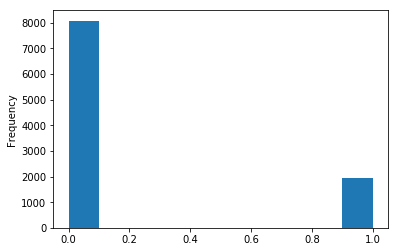

In [463]:
#prediction- order propensity(binary classification model)

print(data['orderflag_last_7days'].value_counts())
print('percent of customer ordered is: %f percent' %((data['orderflag_last_7days'].value_counts()[1]/data['orderflag_last_7days'].shape[0]) * 100))
data['orderflag_last_7days'].astype(int).plot.hist()

In [413]:
print(data.columns)
cust_id = data[['customer_id', 'amount_per_order_3weeks','amount_per_order','Amount in last 7 days','orderflag_last_7days']
              ]
#Use variables excluding last weeks order metrics(3weeks past data to predict last weeks order propensity) 
data_model = data[['Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age',
       'amount_per_order', 'order_per_week_overall','amount_before_lastweek', 'order_before_lastweek', 'amount_last_3weeks',
       'order_last_3weeks', 'amount_per_order_3weeks','order_per_week_3weeks']]

#Handling Categorical Variables-LabelEncoding approach
order_flag_3weeks = pd.get_dummies(data['order_flag_3weeks'])
order_flag_3weeks.columns = ['order_flag_3weeks_0','order_flag_3weeks_1']
data_model = pd.concat([data_model,order_flag_3weeks], axis=1)

data_model.head(2)

Index(['customer_id', 'First Time', 'Recent Time', '# of Orders',
       '# of Orders in last 7 days', '# of Orders in last 4 weeks', 'Amount',
       'Amount in last 7 days', 'Amount in last 4 weeks',
       'Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age',
       'time_dist_ratio', 'amount_per_order', 'order_per_week_overall',
       'amount_per_order_7days', 'amount_per_order_4weeks',
       'order_per_week_4weeks', 'recent_change_amount_per_order',
       'amount_before_lastweek', 'order_before_lastweek', 'amount_last_3weeks',
       'order_last_3weeks', 'amount_per_order_3weeks', 'order_per_week_3weeks',
       'order_flag_4weeks', 'order_flag_3weeks', 'orderflag_last_7days'],
      dtype='object')


,Avg_DistanceFromResturant,Avg_DeliveryTime,cust_age,amount_per_order,order_per_week_overall,amount_before_lastweek,order_before_lastweek,amount_last_3weeks,order_last_3weeks,amount_per_order_3weeks,order_per_week_3weeks,order_flag_3weeks_0,order_flag_3weeks_1
0,0.8,33,158.857143,558.0,0.006295,558,1.0,558,1.0,557.999999,0.333333,0,1
1,2.6,24,176.857143,1342.5,0.011309,2685,2.0,0,0.0,0.000000,0.000000,1,0


In [414]:
from sklearn import preprocessing

sc = preprocessing.StandardScaler()
data_model = sc.fit_transform(data_model)
data_model = pd.DataFrame(data_model)
data_model.columns = ['Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age',
       'amount_per_order', 'order_per_week_overall','amount_before_lastweek', 'order_before_lastweek', 'amount_last_3weeks',
       'order_last_3weeks', 'amount_per_order_3weeks','order_per_week_3weeks','order_flag_3weeks_0','order_flag_3weeks_1']

#Data seperation for development and validation
from sklearn.cross_validation import train_test_split
train_X,validation_X,train_Y,validation_Y,train_cust,validation_cust = train_test_split(data_model,data['orderflag_last_7days'],cust_id, test_size = 0.1, random_state = 20)
print('train_data size:', train_X.shape)
print('validation_data size:', validation_X.shape)
print(train_X.head(2))
print(train_Y.head(2))

train_data size: (9000, 13)
validation_data size: (1000, 13)
      Avg_DistanceFromResturant  Avg_DeliveryTime  cust_age  amount_per_order  \
6706                   0.865550          1.524560 -0.955739          -0.27609   
3527                   0.044929         -0.600717  0.342757          -0.39639   

      order_per_week_overall  amount_before_lastweek  order_before_lastweek  \
6706               -0.461704               -0.381244              -0.448384   
3527                0.793272                0.295458               0.816317   

      amount_last_3weeks  order_last_3weeks  amount_per_order_3weeks  \
6706           -0.347418          -0.434185                -0.444779   
3527           -0.347418          -0.434185                -0.444779   

      order_per_week_3weeks  order_flag_3weeks_0  order_flag_3weeks_1  
6706              -0.434185             0.771295            -0.771295  
3527              -0.434185             0.771295            -0.771295  
6706    0
3527    0
Name

##### Now the data is scaled and model won't be sensitive to magnitude. Now we are ready to build model.This is a binary classification problem(order/not order).There are many m/c learning techniques- Decision Tree,Random Forest,Boosing techniques(GBM,XGBoost etc.),SVM etc. and the ideal way would be to try each of them and take the best one or stacking(prediction from multiple ). Because of time constaint we will be focussing on XGBoost(extreme gradient boosting), a class of boosting method,as modelling technique.

##### XGBoost is also called regularized Gradient Boosting(an ensemble decision tree based algorithm) and in python it comes as an algorithm under sklearn package. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

##### For building this model, as optimization strategy, we try to maximize AUC(area under the curve) metric. To enhance the performance of the model we will do hyperparameter tuning from grid search, varying few key hyperparameters- depth, learning rate,colsample and subsample rate of XGB algorithm and will pick the hyper parameter setting,which will give maximum performance(highest AUC).Offcource there are many more hyperparameters(no of trees,regularization parametrs,min_child_weight etc.) we can play with.  

In [304]:
#Model Building
import lightgbm as lgb
import xgboost as xgb
from ctypes import *
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV 
from xgboost.sklearn import XGBClassifier
import pickle

#Best hyper parameter search

ind_params = {'learning_rate': 0.03, 'n_estimators': 500, 'seed':100,
             'objective': 'gpu:binary:logistic'}
ind_params['nthread'] = 4
ind_params['eval_metric'] = 'auc'
xgb_model = xgb.XGBClassifier(ind_params)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4,5],'subsample': [0.7,0.8], 'colsample_bytree': [0.5,0.6,0.7,0.8],'learning_rate': [0.02,0.03],
                    }, verbose=2,cv=2,scoring='roc_auc')
clf.fit(train_X, train_Y)
clf.best_estimator_

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 -   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.7 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=4, subsample=0.8 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 -   0.3s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.7 -   0.3s
[CV] colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.02, max_depth=5, subsample=0.8 -   0.3s
[CV] colsample_bytree=0.5, learning_rate=0.02,

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   23.0s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

###### As we got the the best hyperparameter combination of XGB, we will train the model again with these hyperparameters(max_depth=5,learning_rate=0.03,subsample=0.7 and colsample_bytree=0.8) to maximize model performance. 

In [356]:
#classification Model train with best hyperparameters

xgb_model = XGBClassifier(n_estimators= 500, max_depth = 5, learning_rate=0.03,subsample=0.7,colsample_bytree=0.8, objective= 'gpu:binary:logistic',silent = False,tree_method = 'gpu_hist')
eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_bst = xgb_model.fit(train_X, train_Y,eval_set=eval_set,early_stopping_rounds=15,verbose = 10,
        eval_metric="auc")

pred = mod_bst.predict(validation_X)

#To calculate binery class accuracy and misclassification error
print('Model accuracy is:{}%'.format(sum(pred==validation_Y)/validation_Y.shape[0]*100)) 
print('Model error rate is:{}%'.format((1-sum(pred==validation_Y)/validation_Y.shape[0])*100))

[13:02:40] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5056MB remaining.
[13:02:40] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5056MB remaining.
[13:02:40] Allocated 1MB on [0] GeForce GTX 1060 with Max-Q Design, 5054MB remaining.
[13:02:40] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5054MB remaining.
[13:02:40] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5054MB remaining.
[0]	validation_0-auc:0.917706	validation_1-auc:0.917939
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[10]	validation_0-auc:0.949789	validation_1-auc:0.940473
[20]	validation_0-auc:0.95241	validation_1-auc:0.946482
[30]	validation_0-auc:0.957725	validation_1-auc:0.951851
[40]	validation_0-auc:0.961312	validation_1-auc:0.957439
[50]	validation_0-auc:0.966441	validation_1-auc:0.964736
[60]	validation_0-auc:0.971162	validation_1-auc:0.969551
[70]	validation_

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Model accuracy is:92.2%
Model error rate is:7.799999999999995%


#### Let's see AUC of the final model. Also following confusion matrix will give us a rough estimation of class wise misclassification rate and other performance metrics like precision, recall, F1score,support etc.

In [359]:
#Model per

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
results = confusion_matrix(validation_Y, pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(validation_Y, pred))
print('Report : ')
print(classification_report(validation_Y, pred)) 

print('model auc is:', metrics.roc_auc_score(validation_Y, mod_bst.predict_proba(validation_X)[:,1]))

Confusion Matrix :
[[778  31]
 [ 47 144]]
Accuracy Score : 0.922
Report : 
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       809
          1       0.82      0.75      0.79       191

avg / total       0.92      0.92      0.92      1000

[13:03:49] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5058MB remaining.
model auc is: 0.9761259133181033


In [466]:
#Writing prediction and saving the model
from sklearn.externals import joblib
pd.DataFrame(pred).to_csv('binary_prediction.csv')
joblib.dump(mod_bst, 'classification_model.dat') 

['classification_model.dat']

###### We can see which variables are important from variable of importance plot

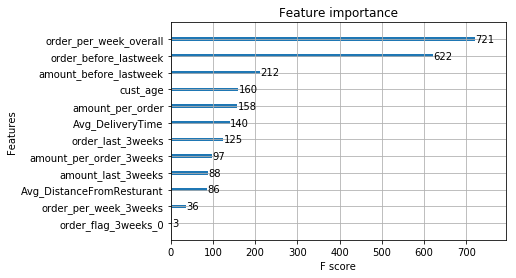

In [467]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(mod_bst)
pyplot.show()

In [468]:
data_model.columns

Index(['Avg_DistanceFromResturant', 'Avg_DeliveryTime', 'cust_age',
       'amount_per_order', 'order_per_week_overall', 'amount_before_lastweek',
       'order_before_lastweek', 'amount_last_3weeks', 'order_last_3weeks',
       'amount_per_order_3weeks', 'order_per_week_3weeks',
       'order_flag_3weeks_0', 'order_flag_3weeks_1'],
      dtype='object')

From these plots we can see that ordering history('order_per_week_overall','order_before_lastweek' etc.) and spend behaviour('amount_before_lastweek') play pivotal role in predicting customer's ordering propensity. Also customers' duration with Swiggy is one of the important variables.

### Now we will build our second stage predictive model- a regression based XGB model to predict no of Orders in last 7 days for individual customer. We will use the same data and follow the same principle of building XGB model except here the dependent variable is '# of Orders in last 7 days' and minimize RMSE(root mean square error).

In [335]:
#2nd stage regression model- prediction for order per week
train_Y,validation_Y = train_test_split(data['# of Orders in last 7 days'], test_size = 0.1, random_state = 20)

#Best hyper parameter search

ind_params = {'n_estimators': 500, 'seed':100,
             'objective': 'gpu:regression'}
ind_params['nthread'] = 4
ind_params['eval_metric'] = 'rmse'
xgb_model = xgb.XGBRegressor(ind_params)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4,5],'subsample': [0.7,0.8], 'colsample_bytree': [0.5,0.6,0.7,0.8],'learning_rate': [0.03,0.04],
                    }, verbose=2,cv=2,scoring='neg_mean_squared_error')
clf.fit(train_X, train_Y)
clf.best_estimator_

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.7 -   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.7 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.8 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, subsample=0.8 -   0.1s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.7 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.7 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.7 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=5, subsample=0.8 -   0.2s
[CV] colsample_bytree=0.5, learning_rate=0.03,

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   21.7s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

###### As we got the the best hyperparameter combination of XGB, we will train the model again with these hyperparameters(max_depth=5,learning_rate=0.04,subsample=0.7 and colsample_bytree=0.8) to maximize model performance. 

In [382]:
#regression Model train with best hyperparameters

xgb_model = xgb.XGBRegressor(n_estimators= 700, max_depth = 5, learning_rate=0.04,subsample=0.7,colsample_bytree=0.8, objective= 'reg:linear',silent = False,tree_method = 'gpu_hist')
eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_bst_regression = xgb_model.fit(train_X, train_Y,eval_set=eval_set,early_stopping_rounds=15,verbose = 10,
        eval_metric="rmse")

pred_order = mod_bst_regression.predict(validation_X)
pred_order = np.where(pred_order < 0,0,pred_order)

#Sanity check Actual mean vs. predicted mean
print(np.mean(pred_order))
print(np.mean(validation_Y))

#To calculate multiclass accuracy and misclassification error
#print('Model accuracy is:{}%'.format(sum(pred==validation_Y)/validation_Y.shape[0]*100)) 
#print('Model error rate is:{}%'.format((1-sum(pred==validation_Y)/validation_Y.shape[0])*100))

[13:28:26] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5050MB remaining.
[13:28:26] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5050MB remaining.
[13:28:26] Allocated 1MB on [0] GeForce GTX 1060 with Max-Q Design, 5048MB remaining.
[13:28:26] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5048MB remaining.
[13:28:26] Allocated 0MB on [0] GeForce GTX 1060 with Max-Q Design, 5048MB remaining.
[0]	validation_0-rmse:0.917451	validation_1-rmse:0.790708
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[10]	validation_0-rmse:0.767426	validation_1-rmse:0.68958
[20]	validation_0-rmse:0.685141	validation_1-rmse:0.641341
[30]	validation_0-rmse:0.622591	validation_1-rmse:0.609378
[40]	validation_0-rmse:0.578932	validation_1-rmse:0.586155
[50]	validation_0-rmse:0.544578	validation_1-rmse:0.563907
[60]	validation_0-rmse:0.517098	validation_1-rmse:0.549384


#### Let's assess performance of this second stage model

In [473]:
print('RMSE metric for no of order prediction:',metrics.mean_squared_error(y_pred=pred_order, y_true=validation_Y))
print('R2 metric for no of order prediction:',metrics.r2_score(y_pred=pred_order, y_true=validation_Y))

RMSE metric for no of order prediction: 0.15523365764058233
R2 metric for no of order prediction: 0.7451576369799481


#### From the coefficient of determination, denoted as R², we can infer that proportion of the variance in the dependent variable(no of Orders in last 7 days) that is predictable from the independent variables is 74.51%.

In [474]:
#Writing prediction and saving the model
from sklearn.externals import joblib
pd.DataFrame(pred_order).to_csv('regression_prediction.csv')
joblib.dump(mod_bst_regression, 'regression_model.dat') 

['regression_model.dat']

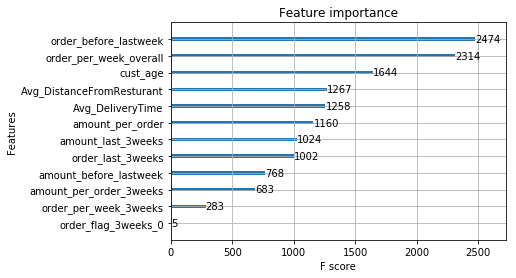

In [475]:
# plot feature importance

from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(mod_bst_regression)
pyplot.show()

#### Almost same type of features emerged as important to predict no of Orders in last 7 days 

#### Now it's time to predict the final metric- customer spend using following formula: 

###### customer spend in last 7 days = (prediction of order in last 7 days) X (Prediction of no of order) X (amount_per_order in overall)

In [487]:
validation_cust['predicted_no_of_order_last_week'] = pred * np.round(pred_order) ## make order quanity as integer
validation_cust['predicted_order_flag'] = pred 
validation_cust['predicted_amount_last_week'] = validation_cust['predicted_no_of_order_last_week'] * (validation_cust['amount_per_order'] + 10**-9)
print(validation_cust[['predicted_amount_last_week']].head(10))
print('R2 metric for this prediction:',metrics.r2_score(y_pred=validation_cust['predicted_amount_last_week'], y_true=validation_cust['Amount in last 7 days']))
validation_cust.to_csv('final_prediction.csv', index=False)

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Sourish\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

      predicted_amount_last_week
9957                   33.500000
1687                    0.000000
2116                    0.000000
231                     0.000000
2780                    0.000000
4578                    0.000000
8260                    0.000000
8557                  207.913043
9523                    0.000000
802                     0.000000
R2 metric for this prediction: 0.6831519357549813


#### So overall it's a decent prediction explaining 68.32% variance in the dependent variable that is predictable from the independent variables. Also as expected in majorly customers past ordering pattern, spend behaviour and customers duration with Swiggy play pivotal role to predict customer's spend in next 7 days.

##                                        Thank You For Your Attention ! Any Questions